In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')

In [2]:
from utils import split_recommender_data, store_eval_images, store_eval_images_per_user

import pandas as pd
import torch
from diffusers.utils import load_image
from tqdm import tqdm

from ncf import NCF
import matplotlib.pyplot as plt

In [3]:
eval_dir = '../data/flickr/evaluation/'
lora_dir = f"{eval_dir}/lora/"
vlm_dir = f"{eval_dir}/vlm_personas/"
vlm_plus_lora_dir = f"{eval_dir}/vlm_personas_plus_lora"
rebeca_dir = f"{eval_dir}/diffusion_priors/models/"
gt_savepath = "../data/flickr/evaluation/ground_truth/per_user"


ncf_model_path = "../data/flickr/evaluation/classifier/"
ncf_model_file = "ncf_scorer_ViT-G.pkl"

ncf = NCF()
ncf.load(f"{ncf_model_path}/{ncf_model_file}")

In [4]:
from diffusers import StableDiffusionXLPipeline
pipe_xl = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
pipe_xl.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
shared_lora_scores = dict()
per_user_lora_scores = dict()
vlm_persona_scores = dict()
vlm_persona_plus_lora_scores = dict()
rebeca_scores = dict()

images_per_user = len(torch.load(f"{lora_dir}/samples_liked/shared/pipecfg_5.0_seed_42_user_0.imgs", weights_only=False) )

for user_id in tqdm(range(210)): 
    # Load user embeddings for all models
    shared_lora_user_images = torch.load(f"{lora_dir}/samples_liked/shared/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False) 
    per_user_lora_user_images = torch.load(f"{lora_dir}/samples_liked/per_user/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    vlm_persona_user_images = torch.load(f"{vlm_dir}/samples/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    vlm_persona_plus_lora_user_images = torch.load(f"{vlm_plus_lora_dir}/samples/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    rebeca_user_images = torch.load(f"{rebeca_dir}/samples/embcfg_5.0_pipecfg_5.0_seed_42/embcfg_5.0_pipecfg_5.0_seed_42_userid_{user_id}.data", weights_only=False)["images"]

    shared_lora_user_embeddings = [] 
    per_user_lora_embeddings = []
    vlm_persona_embeddings = []
    vlm_persona_plus_lora_embeddings = []
    rebeca_embeddings = []
    for i in range(len(shared_lora_user_images)): 
        
        shared_lora_embedding = pipe_xl.encode_image(shared_lora_user_images[i],device="cuda", num_images_per_prompt=1)[0] 
        per_user_lora_embedding = pipe_xl   .encode_image(per_user_lora_user_images[i],device="cuda", num_images_per_prompt=1)[0] 
        vlm_persona_embedding = pipe_xl.encode_image(vlm_persona_user_images[i],device="cuda", num_images_per_prompt=1)[0]
        vlm_persona_plus_lora_embedding = pipe_xl.encode_image(vlm_persona_plus_lora_user_images[i],device="cuda", num_images_per_prompt=1)[0]
        rebeca_embedding = pipe_xl.encode_image(rebeca_user_images[i],device="cuda", num_images_per_prompt=1)[0]
        
        shared_lora_user_embeddings.append(shared_lora_embedding.detach().cpu()) 
        per_user_lora_embeddings.append(per_user_lora_embedding.detach().cpu())
        vlm_persona_embeddings.append(vlm_persona_embedding.detach().cpu())
        vlm_persona_plus_lora_embeddings.append(vlm_persona_plus_lora_embedding.detach().cpu())
        rebeca_embeddings.append(rebeca_embedding.detach().cpu())

    shared_lora_embeddings_tensor = torch.cat(shared_lora_user_embeddings)
    per_user_lora_embeddings_tensor = torch.cat(per_user_lora_embeddings)
    vlm_persona_embeddings_tensor = torch.cat(vlm_persona_embeddings)
    vlm_persona_plus_lora_embeddings_tensor = torch.cat(vlm_persona_plus_lora_embeddings)
    rebeca_embeddings_tensor = torch.cat(rebeca_embeddings)

    shared_lora_scores[user_id] = { "summary": ncf.score(torch.tensor([user_id]).repeat(images_per_user), shared_lora_embeddings_tensor.to(torch.float32)), 
        "raw": ncf.predict(torch.tensor([user_id]).repeat(images_per_user), shared_lora_embeddings_tensor.to(torch.float32))}
    per_user_lora_scores[user_id] = { "summary": ncf.score(torch.tensor([user_id]).repeat(images_per_user), per_user_lora_embeddings_tensor.to(torch.float32)), 
        "raw": ncf.predict(torch.tensor([user_id]).repeat(images_per_user), per_user_lora_embeddings_tensor.to(torch.float32))}
    vlm_persona_scores[user_id] = { "summary": ncf.score(torch.tensor([user_id]).repeat(images_per_user), vlm_persona_embeddings_tensor.to(torch.float32)), 
        "raw": ncf.predict(torch.tensor([user_id]).repeat(images_per_user), vlm_persona_embeddings_tensor.to(torch.float32))}
    vlm_persona_plus_lora_scores[user_id] = { "summary": ncf.score(torch.tensor([user_id]).repeat(images_per_user), vlm_persona_plus_lora_embeddings_tensor.to(torch.float32)), 
        "raw": ncf.predict(torch.tensor([user_id]).repeat(images_per_user), vlm_persona_plus_lora_embeddings_tensor.to(torch.float32))}
    rebeca_scores[user_id] = { "summary": ncf.score(torch.tensor([user_id]).repeat(images_per_user), rebeca_embeddings_tensor.to(torch.float32)),  
        "raw": ncf.predict(torch.tensor([user_id]).repeat(images_per_user), rebeca_embeddings_tensor.to(torch.float32))}



100%|██████████| 210/210 [06:59<00:00,  2.00s/it]


In [6]:
scores = {
    "shared_lora": shared_lora_scores,
    "per_user_lora": per_user_lora_scores,
    "vlm_persona": vlm_persona_scores,
    "vlm_persona_plus_lora": vlm_persona_plus_lora_scores,
    "rebeca": rebeca_scores
}

torch.save(scores, "../data/flickr/evaluation/classifier/scores.pt")


In [7]:
scores = torch.load("../data/flickr/evaluation/classifier/scores.pt", weights_only=False)

In [8]:
def collect(scores_dict, label):
    summaries = []
    raws      = []
    for uid, vals in scores_dict.items():
        summaries.append(float(vals["summary"][uid]["avg"]))
        raws.extend(vals["raw"].detach().cpu().tolist())
    return {"label": label, "summaries": summaries, "raws": raws}


models = [
    collect(shared_lora_scores,"Shared LoRA"),
    collect(per_user_lora_scores,"Per-user LoRA"),
    collect(vlm_persona_scores,"VLM Persona"),
    collect(vlm_persona_plus_lora_scores, "VLM Persona + LoRA")
]

#for embcfg in [3,5,6,9]:
#    models.append(collect(rebeca_scores[embcfg], f"REBECA e{embcfg}"))
models.append(collect(rebeca_scores, f"REBECA"))
import numpy as np
def _to_float(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu()
        return float(x.item()) if x.ndim == 0 else float(x.mean().item())
    return float(np.array(x).mean()) if np.ndim(x) > 0 else float(x)

def collect_per_user_summary(shared_lora_scores=None,
                             per_user_lora_scores=None,
                             vlm_persona_scores=None,
                             vlm_persona_plus_lora_scores=None,
                             rebeca_scores=None,
                             n_users=210):
    """
    Returns:
        model_labels: list[str]
        user_ids: list[int]
        M: np.ndarray shape (n_models, n_users) with summary scores
    Only includes models that are provided (non-None and non-empty).
    """
    model_labels = []
    model_dicts  = []

    if shared_lora_scores:
        model_labels.append("Shared LoRA")
        model_dicts.append(shared_lora_scores)
    if per_user_lora_scores:
        model_labels.append("Per-user LoRA")
        model_dicts.append(per_user_lora_scores)
    if vlm_persona_scores:
        model_labels.append("VLM Persona")
        model_dicts.append(vlm_persona_scores)
    if vlm_persona_plus_lora_scores:
        model_labels.append("VLM Persona + LoRA")
        model_dicts.append(vlm_persona_plus_lora_scores)
    if rebeca_scores:  
        model_labels.append(f"REBECA")
        model_dicts.append(rebeca_scores)

    user_ids = list(range(n_users))
    M = np.zeros((len(model_labels), n_users), dtype=float)

    for mi, d in enumerate(model_dicts):
        for uid in user_ids:
            if uid not in d:
                M[mi, uid] = np.nan
            else:
                M[mi, uid] = _to_float(d[uid]["summary"][uid]["avg"])
    return model_labels, user_ids, M


In [9]:
labels, user_ids, M = collect_per_user_summary(
    shared_lora_scores=shared_lora_scores,
    per_user_lora_scores=per_user_lora_scores,
    vlm_persona_scores=vlm_persona_scores,
    vlm_persona_plus_lora_scores=vlm_persona_plus_lora_scores,
    rebeca_scores=rebeca_scores,   # {3:...,6:...,9:...}
    n_users=210
)


/tmp/ipykernel_1832024/553284756.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis").with_extremes(bad="#f0f0f0")
/tmp/ipykernel_1832024/553284756.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


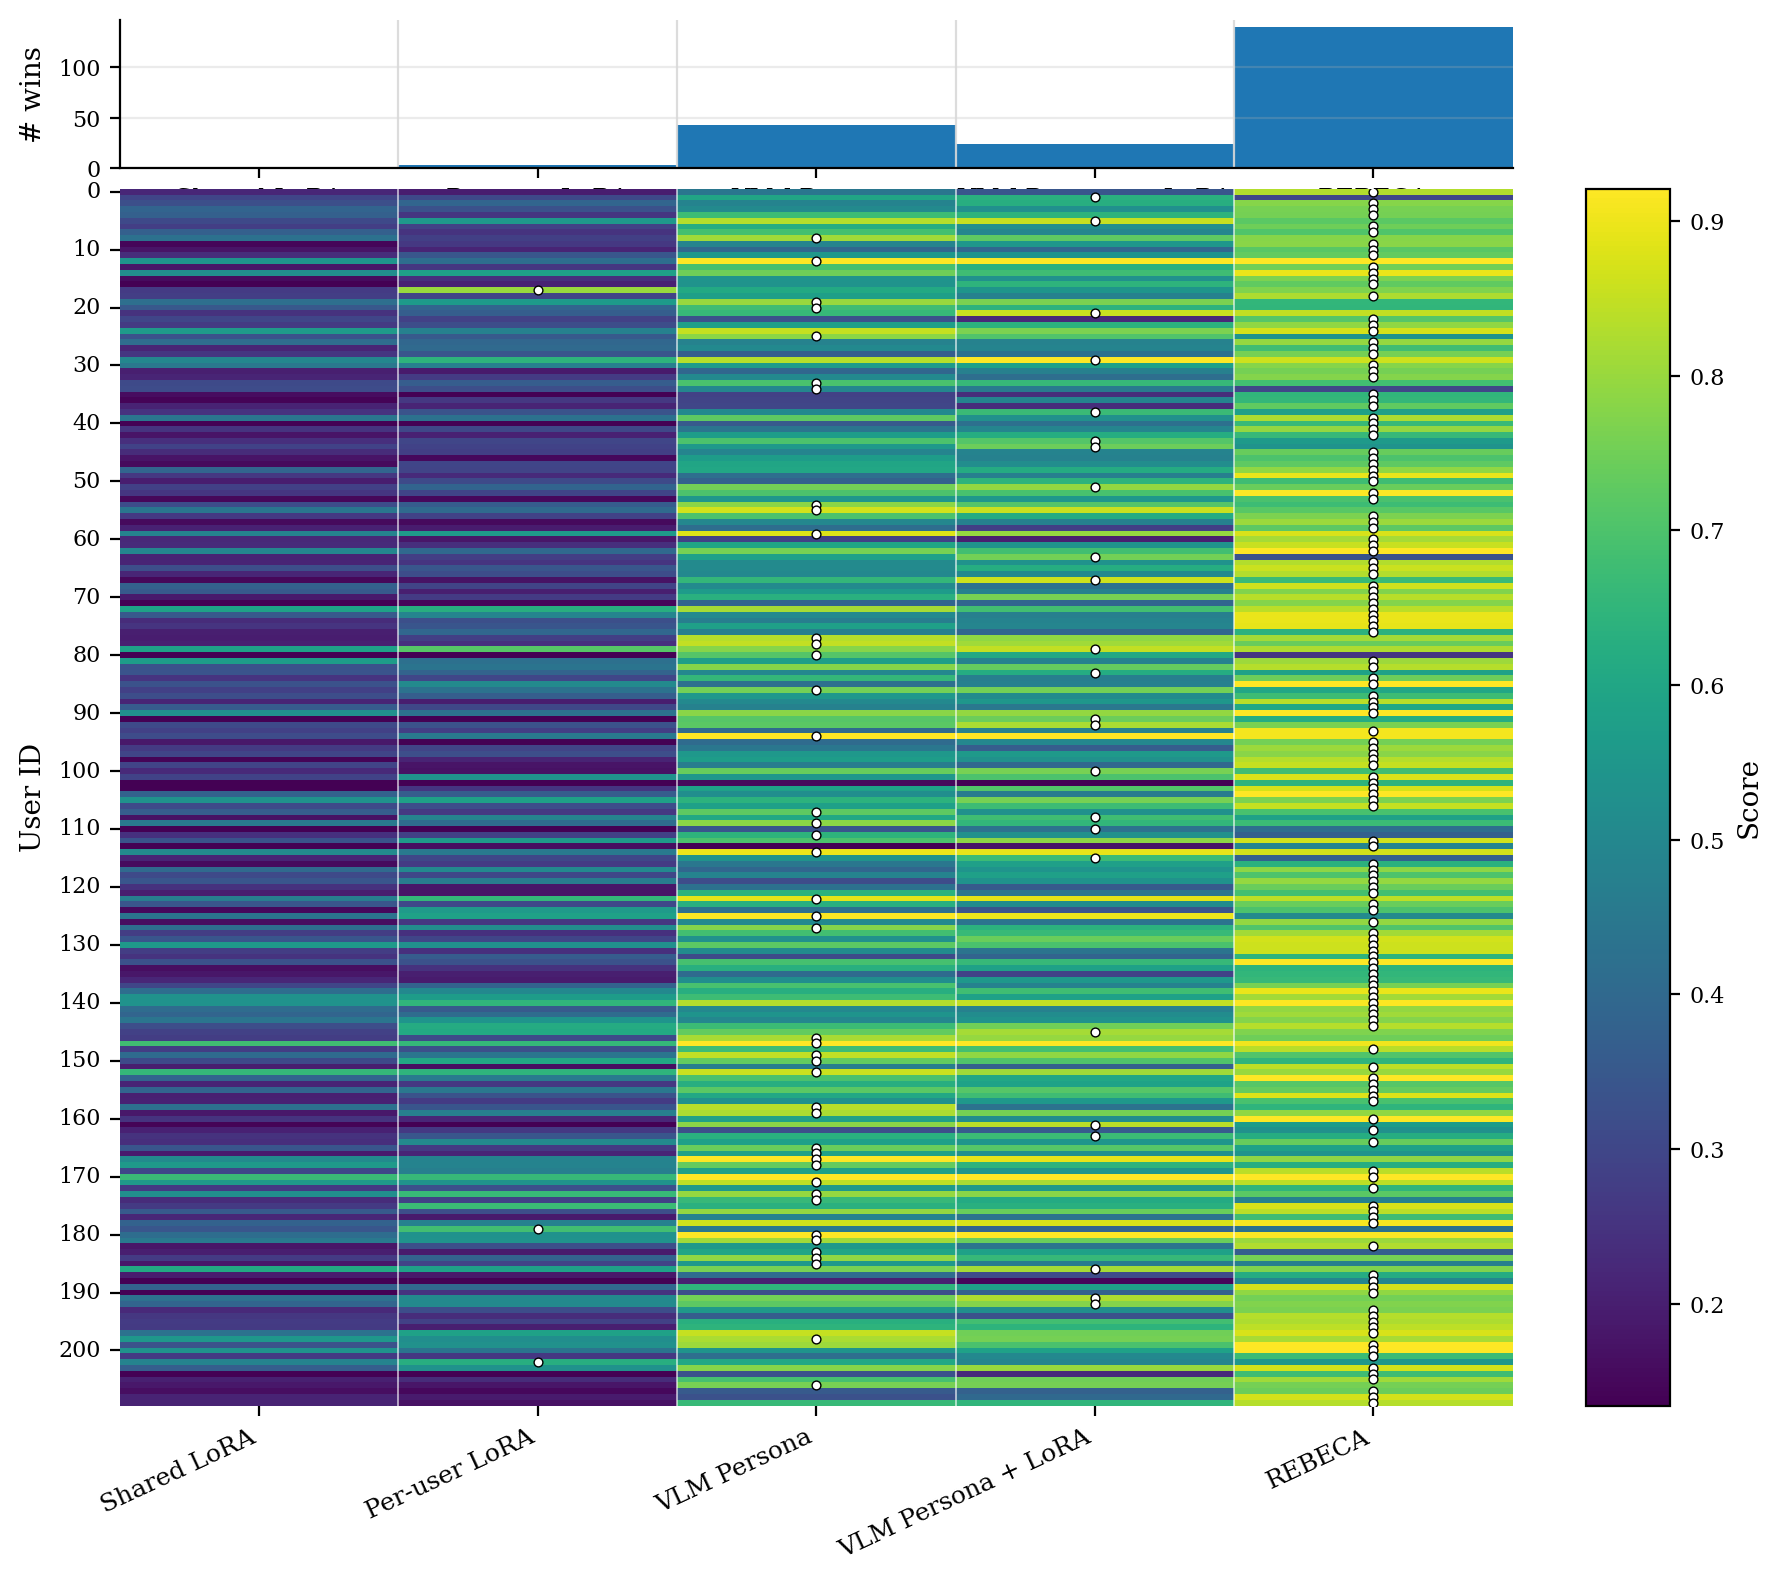

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap_cvpr_topwins_aligned(M, labels, user_ids, *,
                                      ytick_every=10,
                                      add_argmax_dots=True,
                                      savepath=None):
    """
    - No sorting
    - Wins bar on TOP (aligned)
    - Heatmap in the middle
    - Slim colorbar in a dedicated column (doesn't distort alignment)
    - Clear model demarcation lines and tick labels
    M is [n_users, n_models] (if you have [n_models, n_users], pass M.T)
    """
    # ---- style ----
    mpl.rcParams.update({
        "figure.dpi": 200, "savefig.dpi": 300,
        "font.family": "serif", "font.size": 10,
        "axes.spines.top": False, "axes.spines.right": False,
        "xtick.labelsize": 9, "ytick.labelsize": 8,
    })

    M = np.array(M, dtype=float)
    r, c = M.shape
    if c != len(labels) and r == len(labels) and len(user_ids) == c:
        M = M.T
        r, c = M.shape
    assert M.shape[1] == len(labels)
    assert M.shape[0] == len(user_ids)

    # drop all-NaN rows
    keep = ~np.all(np.isnan(M), axis=1)
    M = M[keep]
    users = [u for u, k in zip(user_ids, keep) if k]
    n_users, n_models = M.shape

    # robust color scale
    vals = M[~np.isnan(M)]
    if vals.size:
        vmin, vmax = np.percentile(vals, 2), np.percentile(vals, 98)
        if vmin >= vmax: vmin, vmax = vals.min(), vals.max()
    else:
        vmin = vmax = None
    cmap = mpl.cm.get_cmap("viridis").with_extremes(bad="#f0f0f0")

    # ---- Grid: 2 rows (wins+heatmap) × 2 cols (plot + colorbar) ----
    # left column hosts both top bar and heatmap (same width), right column is cbar only
    fig = plt.figure(figsize=(max(10.0, n_models * 0.95), 9.0))
    gs = fig.add_gridspec(
        nrows=2, ncols=2,
        width_ratios=[30, 1.8],       # narrow cbar col
        height_ratios=[2.2, 18.0],    # top wins bar smaller
        wspace=0.10, hspace=0.03
    )

    ax_top = fig.add_subplot(gs[0, 0])
    ax_hm  = fig.add_subplot(gs[1, 0], sharex=ax_top)
    cax    = fig.add_subplot(gs[1, 1])   # colorbar aligned with heatmap row

    # ---- heatmap (no internal cbar) ----
    hm = sns.heatmap(
        M, ax=ax_hm, cmap=cmap, vmin=vmin, vmax=vmax,
        mask=np.isnan(M),
        xticklabels=labels, yticklabels=users,
        cbar=False, linewidths=0, square=False
    )
    # ticks at cell centers and fixed limits so everything aligns
    ax_hm.set_xlim(0, n_models)
    ax_hm.set_xticks(np.arange(n_models) + 0.5)
    #ax_hm.set_xlabel("Model")
    ax_hm.set_ylabel("User ID")
    ax_hm.set_xticks(np.arange(n_models) + 0.5)
    ax_hm.set_xticklabels(labels, rotation=25, ha="right")


    # sparse y-ticks
    if ytick_every and ytick_every > 0:
        inds = list(range(0, n_users, ytick_every))
        ax_hm.set_yticks([i + 0.5 for i in inds])
        ax_hm.set_yticklabels([str(users[i]) for i in inds])
    else:
        ax_hm.set_yticklabels([])

    # vertical column separators (both axes)
    for x in range(1, n_models):
        ax_hm.axvline(x, color="w", lw=0.6, alpha=0.7, zorder=2)
        ax_top.axvline(x, color="0.85", lw=0.8, alpha=0.9, zorder=2)

    # winner dots
    if add_argmax_dots:
        with np.errstate(invalid="ignore"):
            winners = np.nanargmax(M, axis=1)
        ycoords = np.arange(n_users) + 0.5
        xcoords = winners + 0.5
        ax_hm.scatter(xcoords, ycoords, s=10, c="white",
                      edgecolors="black", linewidths=0.5, zorder=3)

    # rasterize the heavy heatmap artist only
    if ax_hm.collections:
        ax_hm.collections[0].set_rasterized(True)

    # ---- top '# wins' bar (aligned) ----
    counts = np.zeros(n_models, dtype=int)
    for i in range(n_users):
        row = M[i]
        if np.all(np.isnan(row)): continue
        j = np.argmax(np.nan_to_num(row, nan=-1e9))
        counts[j] += 1

    xcenters = np.arange(n_models) + 0.5
    ax_top.bar(xcenters, counts, width=1.0, align="center")
    ax_top.set_xlim(0, n_models)
    ax_top.set_ylabel("# wins")
    # no x tick labels on the top axis
    ax_top.set_xticks(np.arange(n_models) + 0.5)
    #ax_top.set_xticklabels([])
    ax_top.grid(True, axis="y", alpha=0.25)

    # ---- colorbar in its own column ----
    cb = fig.colorbar(hm.collections[0], cax=cax)
    cb.set_label("Score")

    fig.tight_layout()
    if savepath:
        base = savepath.rstrip(".pdf").rstrip(".png")
        fig.savefig(base + ".pdf", bbox_inches="tight")
        fig.savefig(base + ".png", bbox_inches="tight", dpi=300)
    return fig, (ax_top, ax_hm, cax)


# If your original M was [models x users], pass M.T
fig, _ = plot_heatmap_cvpr_topwins_aligned(M.T, labels, user_ids,
                                           ytick_every=10,
                                           add_argmax_dots=True,
                                           savepath="figs/heatmap_main")


/tmp/ipykernel_1832024/1259366190.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


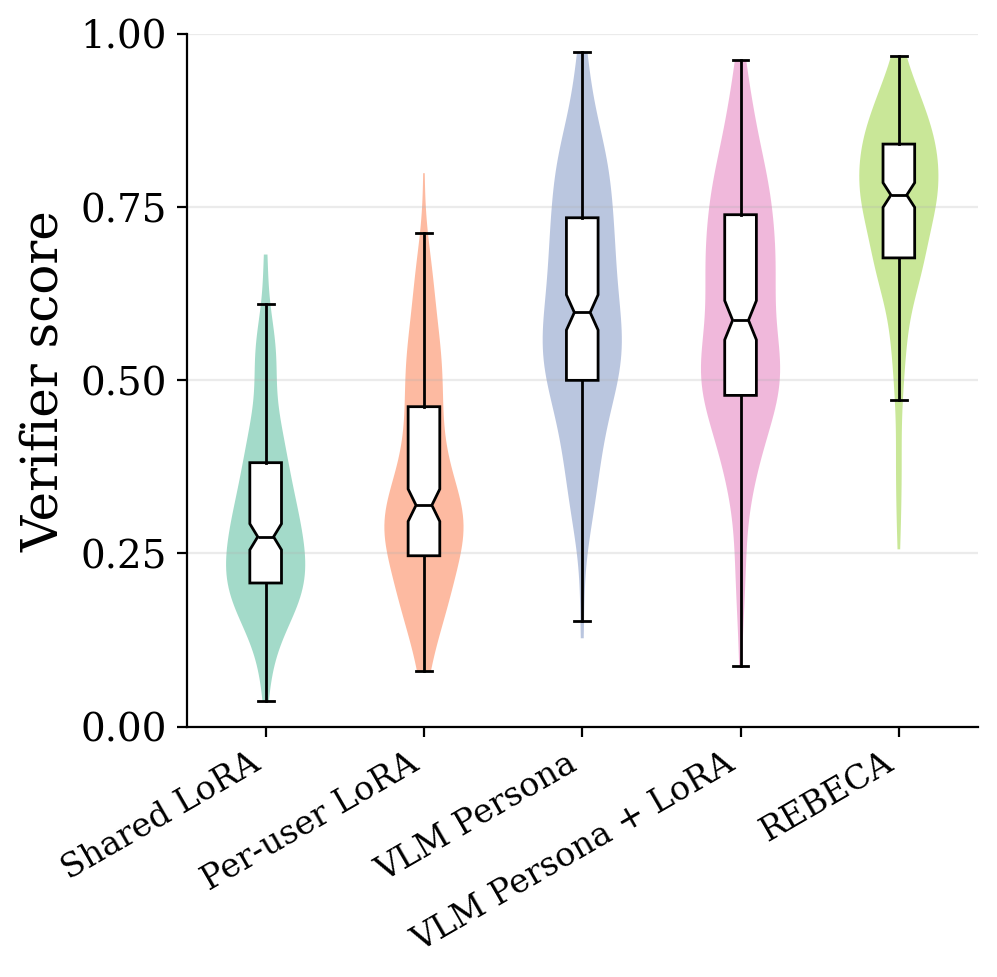

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon


def per_model_distributions_fig(
    M, labels, *, baseline_label="Shared LoRA", focus_label="REBECA e9",
    showfliers=False, savepath=None
):
    # ---- aesthetics
    mpl.rcParams.update({
        "figure.dpi": 200, "savefig.dpi": 300,
        "font.size": 11, "axes.titlesize": 13, "axes.labelsize": 12,
        "xtick.labelsize": 12, "ytick.labelsize": 14,
        "axes.spines.right": False, "axes.spines.top": False,
    })
    cmap = sns.color_palette("Set2", n_colors=len(labels))

    # keep only users with non-NaN across focus/baseline for paired stats
    L = {lab:i for i,lab in enumerate(labels)}
    if baseline_label not in L or focus_label not in L:
        raise ValueError("baseline_label or focus_label not in labels")
    b, f = L[baseline_label], L[focus_label]
    mask = ~np.isnan(M[:, b]) & ~np.isnan(M[:, f])
    M_pair = M[mask]


    # ---- figure with 3 panels
    fig = plt.figure(figsize=(12, 4.5))
    gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.8, 1.8], wspace=0.35)

    # (A) Violin + box overlay per model (all users)
    axA = fig.add_subplot(gs[0,0])
    data = [M[:, i][~np.isnan(M[:, i])] for i in range(M.shape[1])]
    # violins
    parts = axA.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap[i]); pc.set_edgecolor('none'); pc.set_alpha(0.6)
    # boxes (notched)
    bp = axA.boxplot(data, sym='' if not showfliers else 'o', showfliers=showfliers,
                     notch=True, widths=0.2, patch_artist=True)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor("white"); patch.set_edgecolor('black'); patch.set_linewidth(1.0)
    for elem in ['whiskers','caps','medians']:
        for l in bp[elem]: l.set_color('black'); l.set_linewidth(1.0)

    axA.set_xticks(np.arange(1, len(labels)+1))
    axA.set_xticklabels(labels, rotation=25, ha="right")
    axA.set_ylabel("Verifier score", fontsize=18)
    #axA.set_title("Model distributions")
    axA.grid(True, axis="y", alpha=0.25)


    
    plt.tight_layout()

    axA.set_yticks(np.arange(0,1.01,0.25))
    #axC.set_yticks(np.arange(0,1.01,0.25))

    axA.set_ylim(0,1)
    #axC.set_ylim(0,1)
    for ax in [axA]:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_ha("right")


    if savepath:
        for ext in (".pdf", ".png", ".svg"):
            out = savepath if savepath.endswith(ext) else savepath + ext
            plt.savefig(out, bbox_inches="tight")

    plt.show()

# ---- Example usage ----
per_model_distributions_fig(
    M.T, labels,
    baseline_label='VLM Persona',
    focus_label="REBECA",
    showfliers=False,
    savepath="figs/model_comparison"
)


## Aesthetic Predictors

In [19]:
# === Setup ====================================================================
import os, numpy as np, torch
from tqdm import tqdm
import hpsv2
from aesthetics_predictor import AestheticsPredictorV2Linear
from transformers import CLIPImageProcessor


device     = "cuda" if torch.cuda.is_available() else "cpu"
BATCH      = 128
HPS_VER    = "v2.0"     
HPS_PROMPT = "Realistic image, finely detailed, with balanced composition and harmonious elements."    
LAION_ID   = "shunk031/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE"

# Init LAION predictor once
laion_pred = AestheticsPredictorV2Linear.from_pretrained(LAION_ID).to(device).eval()
laion_proc = CLIPImageProcessor.from_pretrained(LAION_ID)


@torch.no_grad()
def score_hpsv2_pil(pils, prompt=HPS_PROMPT, hps_version=HPS_VER, batch_size=BATCH):
    scores = []
    for i in range(0, len(pils), batch_size):
        out = hpsv2.score(pils[i:i+batch_size], prompt, hps_version=hps_version)
        if isinstance(out, dict):
            s = out.get("hps") or out.get("score") or list(out.values())[0]
        else:
            s = out
        scores.extend([float(x) for x in s])
    return scores  

@torch.no_grad()
def score_laion_pil(pils, batch_size=BATCH):
    scores = []
    for i in range(0, len(pils), batch_size):
        inputs = laion_proc(images=pils[i:i+batch_size], return_tensors="pt").to(device)
        out = laion_pred(**inputs)                 # .logits [B,1]
        scores.extend(out.logits.squeeze(-1).detach().cpu().tolist())
    return [float(x) for x in scores]

eval_dir = '../data/flickr/evaluation/'
lora_dir = f"{eval_dir}/lora/"
vlm_dir = f"{eval_dir}/vlm_personas/"
vlm_plus_lora_dir = f"{eval_dir}/vlm_personas_plus_lora"
rebeca_dir = f"{eval_dir}/diffusion_priors/models/"


def load_user_images(user_id):
    shared   = torch.load(f"{lora_dir}/samples_liked/shared/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    peruser  = torch.load(f"{lora_dir}/samples_liked/per_user/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    vlm      = torch.load(f"{vlm_dir}/samples/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    vlm_lora = torch.load(f"{vlm_plus_lora_dir}/samples/pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
    rebeca_d = torch.load(f"{rebeca_dir}/samples/embcfg_5.0_pipecfg_5.0_seed_42/embcfg_5.0_pipecfg_5.0_seed_42_userid_{user_id}.data",
                          weights_only=False)
    rebeca   = rebeca_d["images"]  # should be list[PIL]; if tensors, convert to PIL before scoring

    return {
        "Shared LoRA": shared,
        "Per-user LoRA": peruser,
        "VLM Persona": vlm,
        "VLM Persona + LoRA": vlm_lora,
        "REBECA": rebeca,
    }

# === Main per-user streaming evaluation =======================================
def evaluate_streaming(num_users=210, prompt=HPS_PROMPT, save_raw_dir=None):
    """
    Streams users to keep memory low.
    Returns:
      per_user_means = {
          "hps":   {model: np.array([mean_u for u in users])},
          "laion": {model: np.array([mean_u for u in users])},
      }
    Optionally writes raw per-image scores to disk (one JSON per user) if save_raw_dir is set.
    """
    model_names = ["Shared LoRA","Per-user LoRA","VLM Persona","VLM Persona + LoRA","REBECA"]
    per_user_means = {"hps": {m: [] for m in model_names},
                      "laion": {m: [] for m in model_names}}

    if save_raw_dir:
        os.makedirs(save_raw_dir, exist_ok=True)

    for user_id in tqdm(range(num_users), desc="Scoring users"):
        data = load_user_images(user_id)

        # Score HPS + LAION for each model for this user
        raw_user = {"user_id": user_id, "hps": {}, "laion": {}}
        for m in model_names:
            pils = data[m]
            if len(pils) == 0:  # handle empty user gracefully
                per_user_means["hps"][m].append(np.nan)
                per_user_means["laion"][m].append(np.nan)
                raw_user["hps"][m] = []
                raw_user["laion"][m] = []
                continue

            hps_scores   = score_hpsv2_pil(pils, prompt=prompt)
            laion_scores = score_laion_pil(pils)

            per_user_means["hps"][m].append(float(np.mean(hps_scores)))
            per_user_means["laion"][m].append(float(np.mean(laion_scores)))
            raw_user["hps"][m]   = hps_scores
            raw_user["laion"][m] = laion_scores

        # optional: persist raw per-user scores to avoid holding in RAM
        if save_raw_dir:
            import json
            with open(os.path.join(save_raw_dir, f"user_{user_id:03d}.json"), "w") as f:
                json.dump(raw_user, f)

    # stack to arrays
    for metric in ["hps","laion"]:
        for m in model_names:
            per_user_means[metric][m] = np.array(per_user_means[metric][m], dtype=float)

    return per_user_means




In [ ]:
per_user_means_T1 = evaluate_streaming(num_users=210, prompt=HPS_PROMPT, save_raw_dir=None)
per_user_means = evaluate_streaming(num_users=210, prompt=".", save_raw_dir=None)

torch.save(per_user_means_T1, "../data/flickr/evaluation/aesthetic_predictors/per_user_means_T1.pth")
torch.save(per_user_means, "../data/flickr/evaluation/aesthetic_predictors/per_user_means.pth")

Scoring users:   0%|          | 0/210 [00:00<?, ?it/s]/home/gabriel/anaconda3/envs/rebeca-env/lib/python3.13/site-packages/hpsv2/img_score.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Scoring users: 100%|██████████| 210/210 [24:01<00:00,  6.86s/it]


In [20]:
per_user_means = torch.load("../data/flickr/evaluation/aesthetic_predictors/per_user_means.pth", weights_only=False)
per_user_means_T1 = torch.load("../data/flickr/evaluation/aesthetic_predictors/per_user_means_T1.pth", weights_only=False)

In [45]:
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_box_distributions(per_user_means, metric="hps", title=None, savepath=None,
                           showfliers=False, use_percentile_whiskers=True):
    """
    Violin + box overlay (CVPR-friendly but colorful), per-user means per model.
    - Colorful Set2 violins (alpha=0.6), white notched boxes overlaid.
    - Optional 5–95 percentile whiskers (robust) or default IQR whiskers.
    - Mean marker (●) on top of each box, sample size n annotated.
    - Light y-grid, rotated x-ticks, tight layout.
    """
    # ---- aesthetics (compact, print-friendly) ----
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.transparent": True,
        "font.family": "serif",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })

    def _model_order(d):
        wanted = ["Shared LoRA","Per-user LoRA","VLM Persona","VLM Persona + LoRA","REBECA"]
        return [m for m in wanted if m in d]

    def _clean(x):
        x = np.asarray(x, float)
        return x[np.isfinite(x)]

    data_dict = per_user_means[metric]
    models = _model_order(data_dict)
    vals = [_clean(data_dict[m]) for m in models]

    # Color palette (one per model)
    cmap = sns.color_palette("Set2", n_colors=len(models))

    fig, ax = plt.subplots(figsize=(12, 6))


    # ---------------- Violin layer ----------------
    vp = ax.violinplot(vals, showmeans=False, showmedians=False, showextrema=False)
    for i, body in enumerate(vp['bodies']):
        body.set_facecolor(cmap[i])
        body.set_edgecolor("none")
        body.set_alpha(0.6)

    # ---------------- Box layer (overlaid) ----------------
    whisk = (5, 95) if use_percentile_whiskers else 1.5  # 5–95% or IQR*1.5
    bp = ax.boxplot(
        vals,
        sym='' if not showfliers else 'o',
        showfliers=showfliers,
        notch=True,
        widths=0.2,
        patch_artist=True,
        whis=whisk
    )

    for box in bp["boxes"]:
        box.set(facecolor="white", edgecolor="black", linewidth=1.1)
    for med in bp["medians"]:
        med.set(color="black", linewidth=1.5)
    for whisker in bp["whiskers"]:
        whisker.set(color="black", linewidth=1.0)
    for cap in bp["caps"]:
        cap.set(color="black", linewidth=1.0)

    # ---------------- Mean markers + n annotations ----------------
    x_pos = np.arange(1, len(models) + 1)
    for i, (x, v) in enumerate(zip(x_pos, vals)):
        if len(v) == 0:
            continue
        mu = float(np.mean(v))
        ax.plot([x], [mu], marker="o", markersize=4.2, color="#111111", zorder=3)
        # annotate n at top whisker (or near max)
        y_top = np.percentile(v, 97.5) if len(v) > 4 else np.max(v)
        #ax.text(x, y_top, f" n={len(v)}", ha="center", va="bottom", fontsize=9, color="#333333", clip_on=False)

    # ---------------- Axes, labels, grid ----------------
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, rotation=25, ha="right", fontsize=24)
    ax.set_ylabel(f"{metric.upper()} score", fontsize=24)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    ax.grid(True, axis="y", alpha=0.25, linewidth=0.8)

    if title:
        ax.set_title(title, pad=6)

    fig.tight_layout(pad=0.6)

    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()




/tmp/ipykernel_1808191/1777147499.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


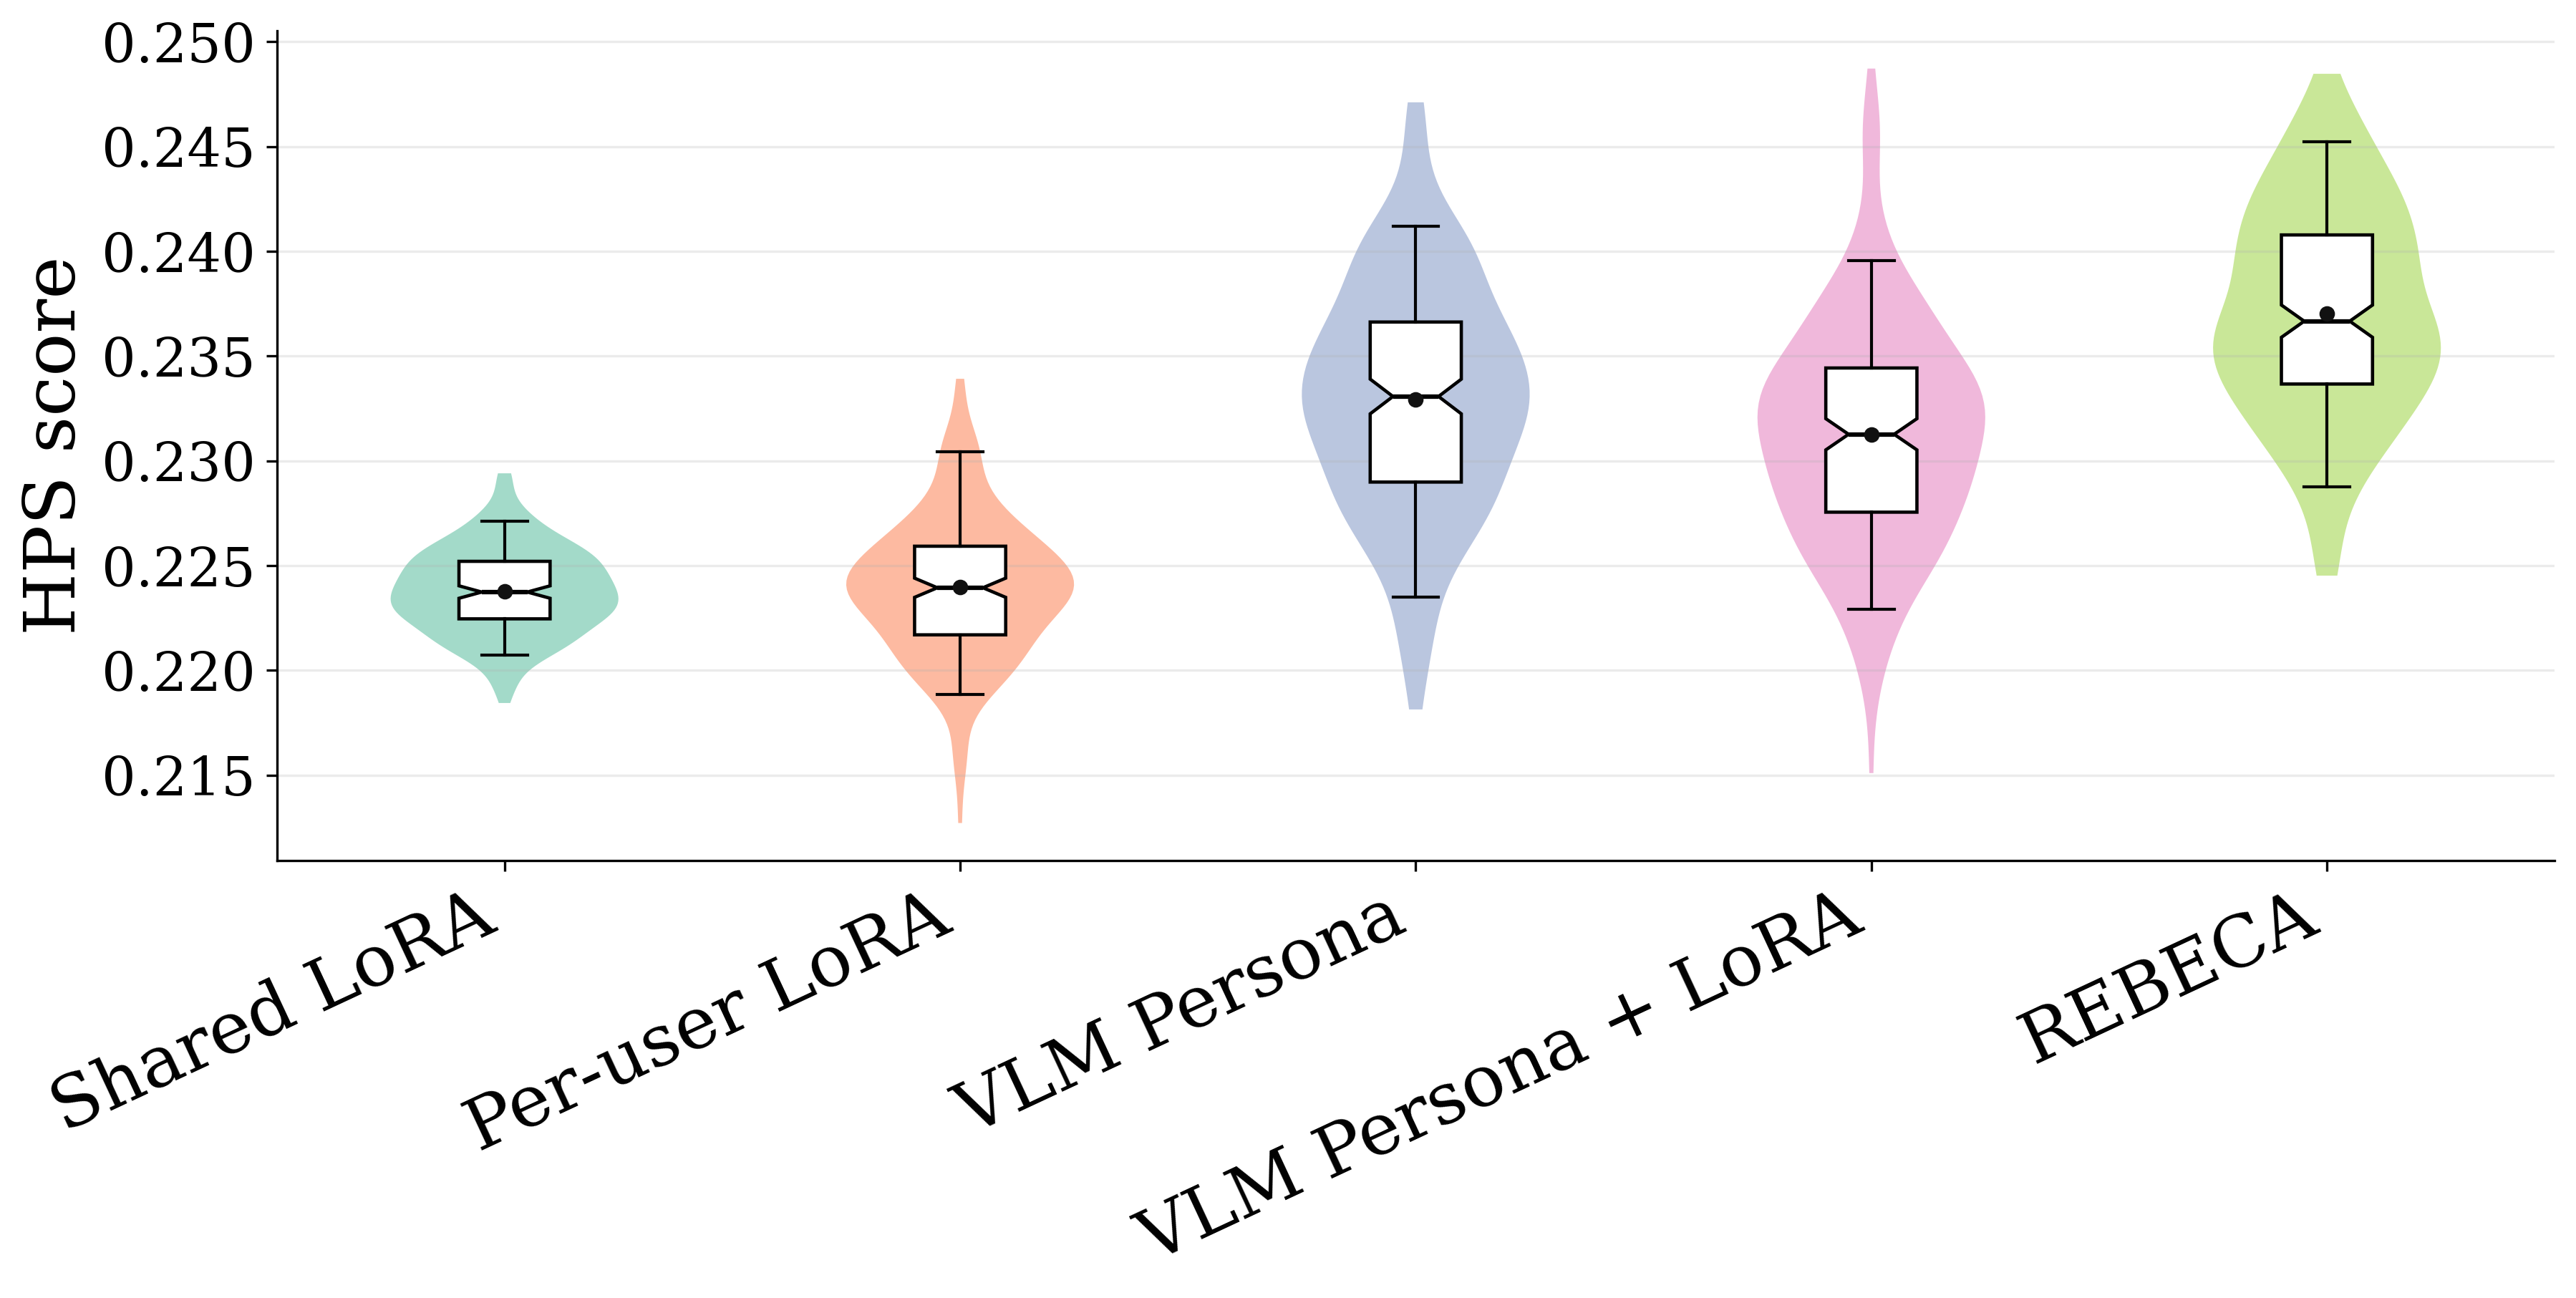

/tmp/ipykernel_1808191/1777147499.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


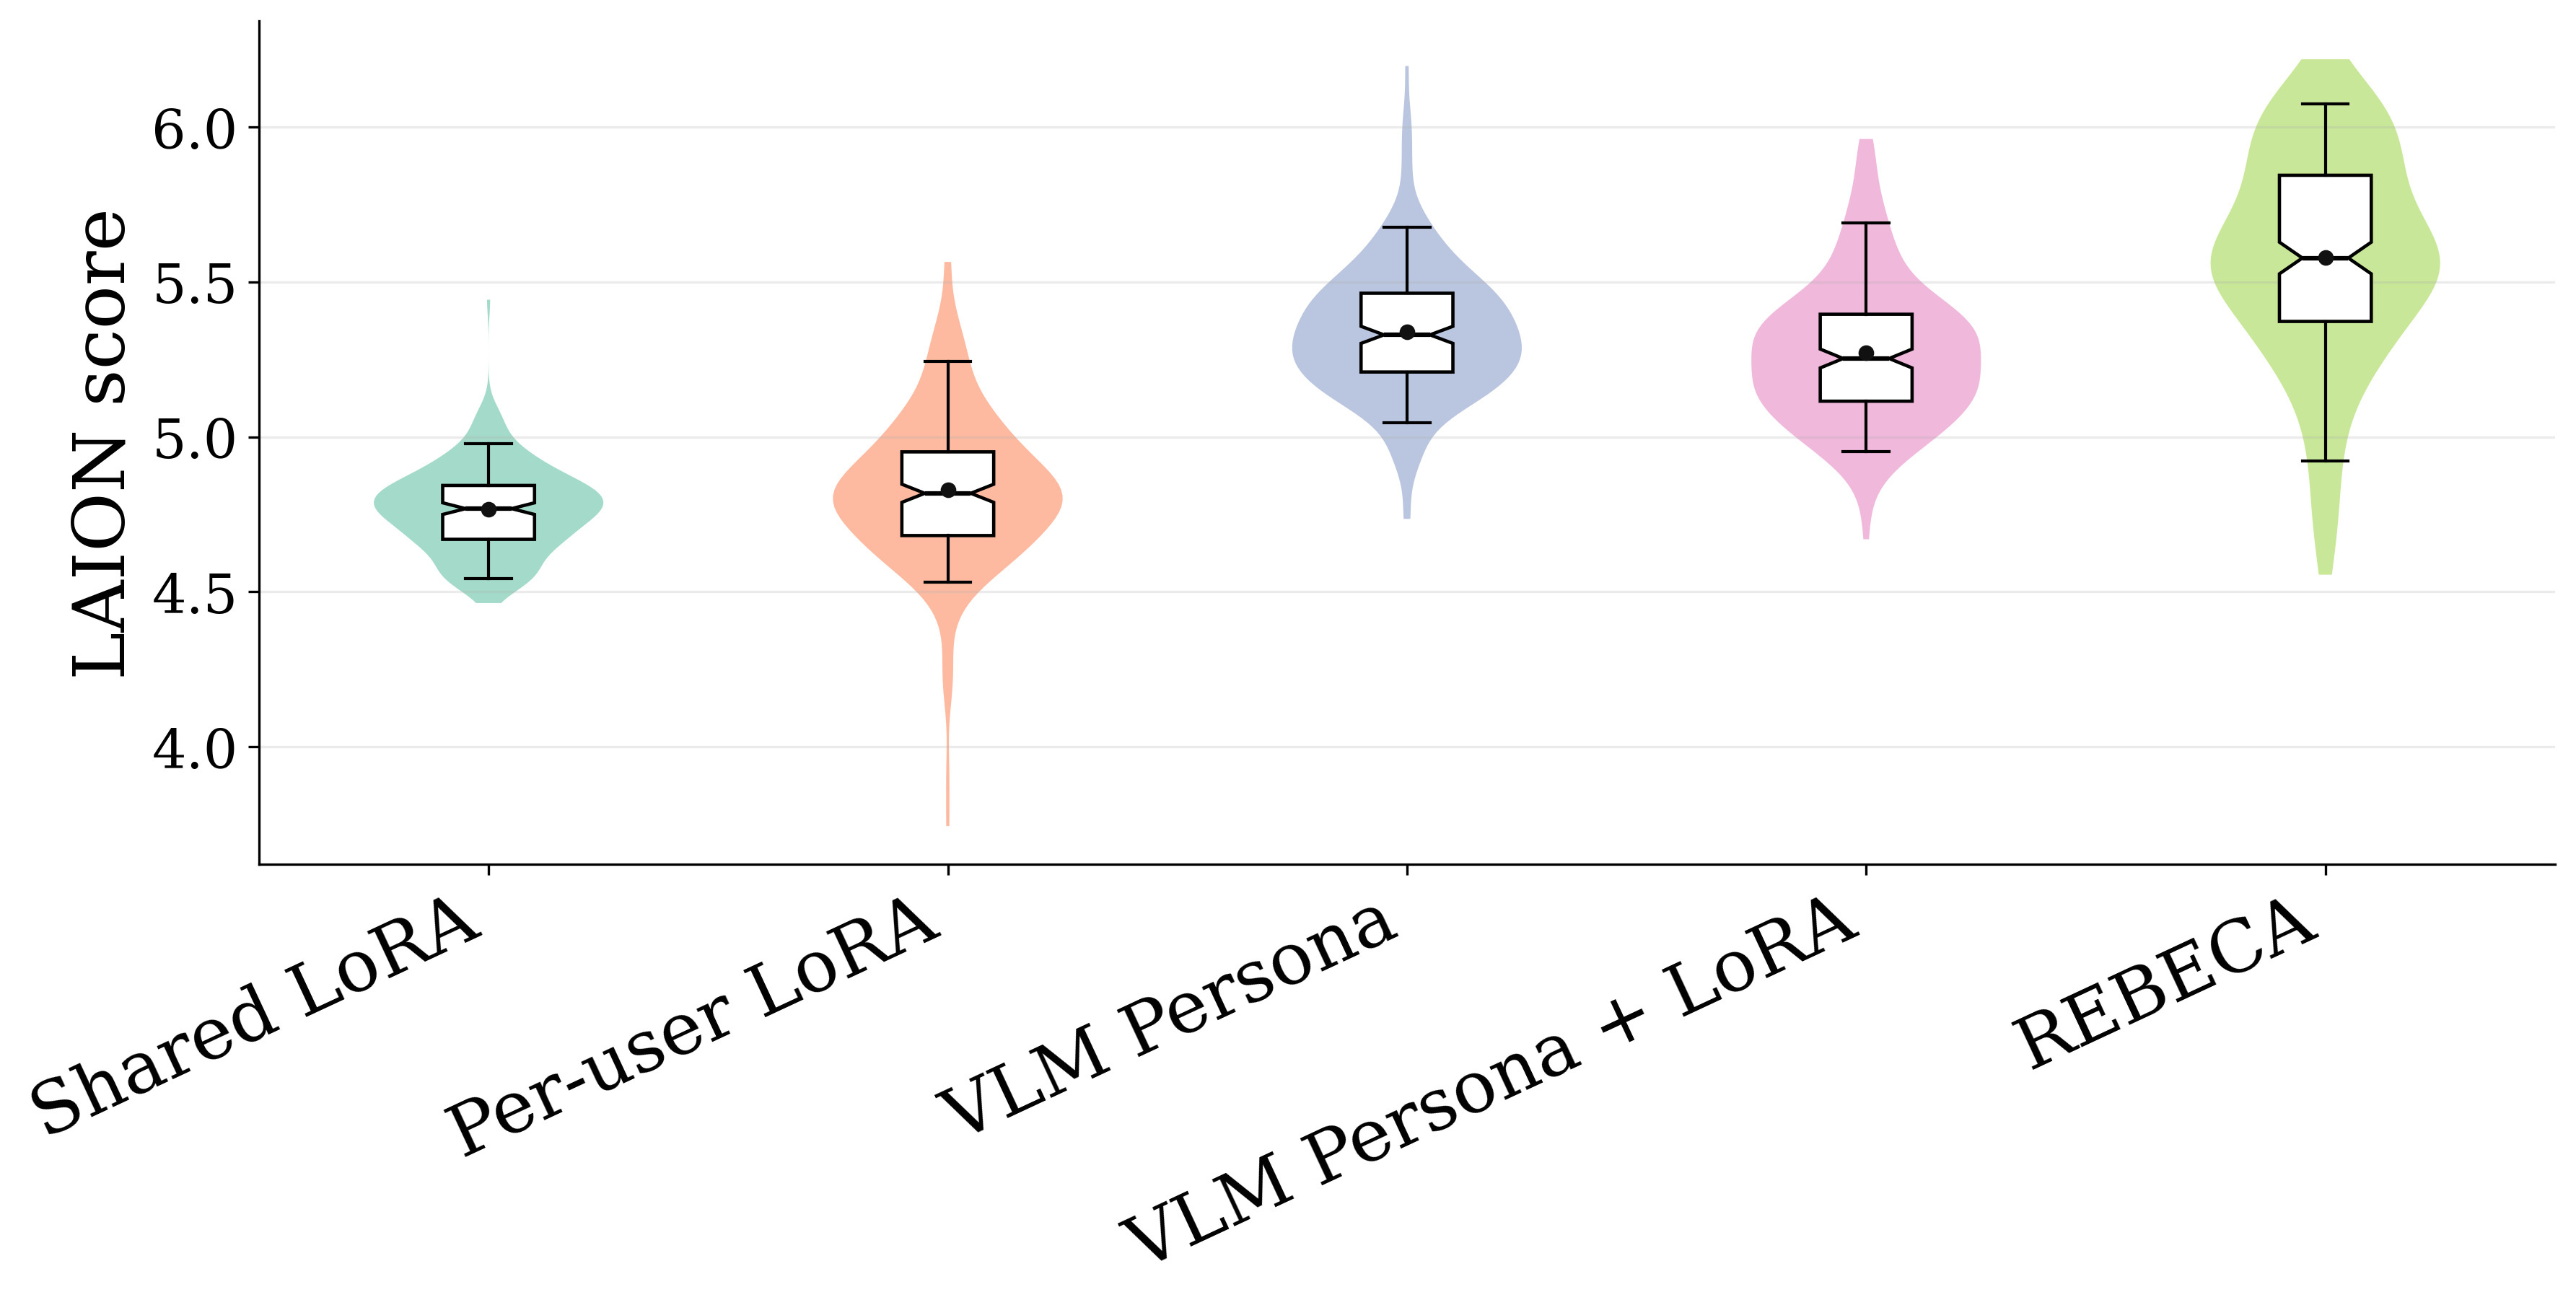

/tmp/ipykernel_1808191/1777147499.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


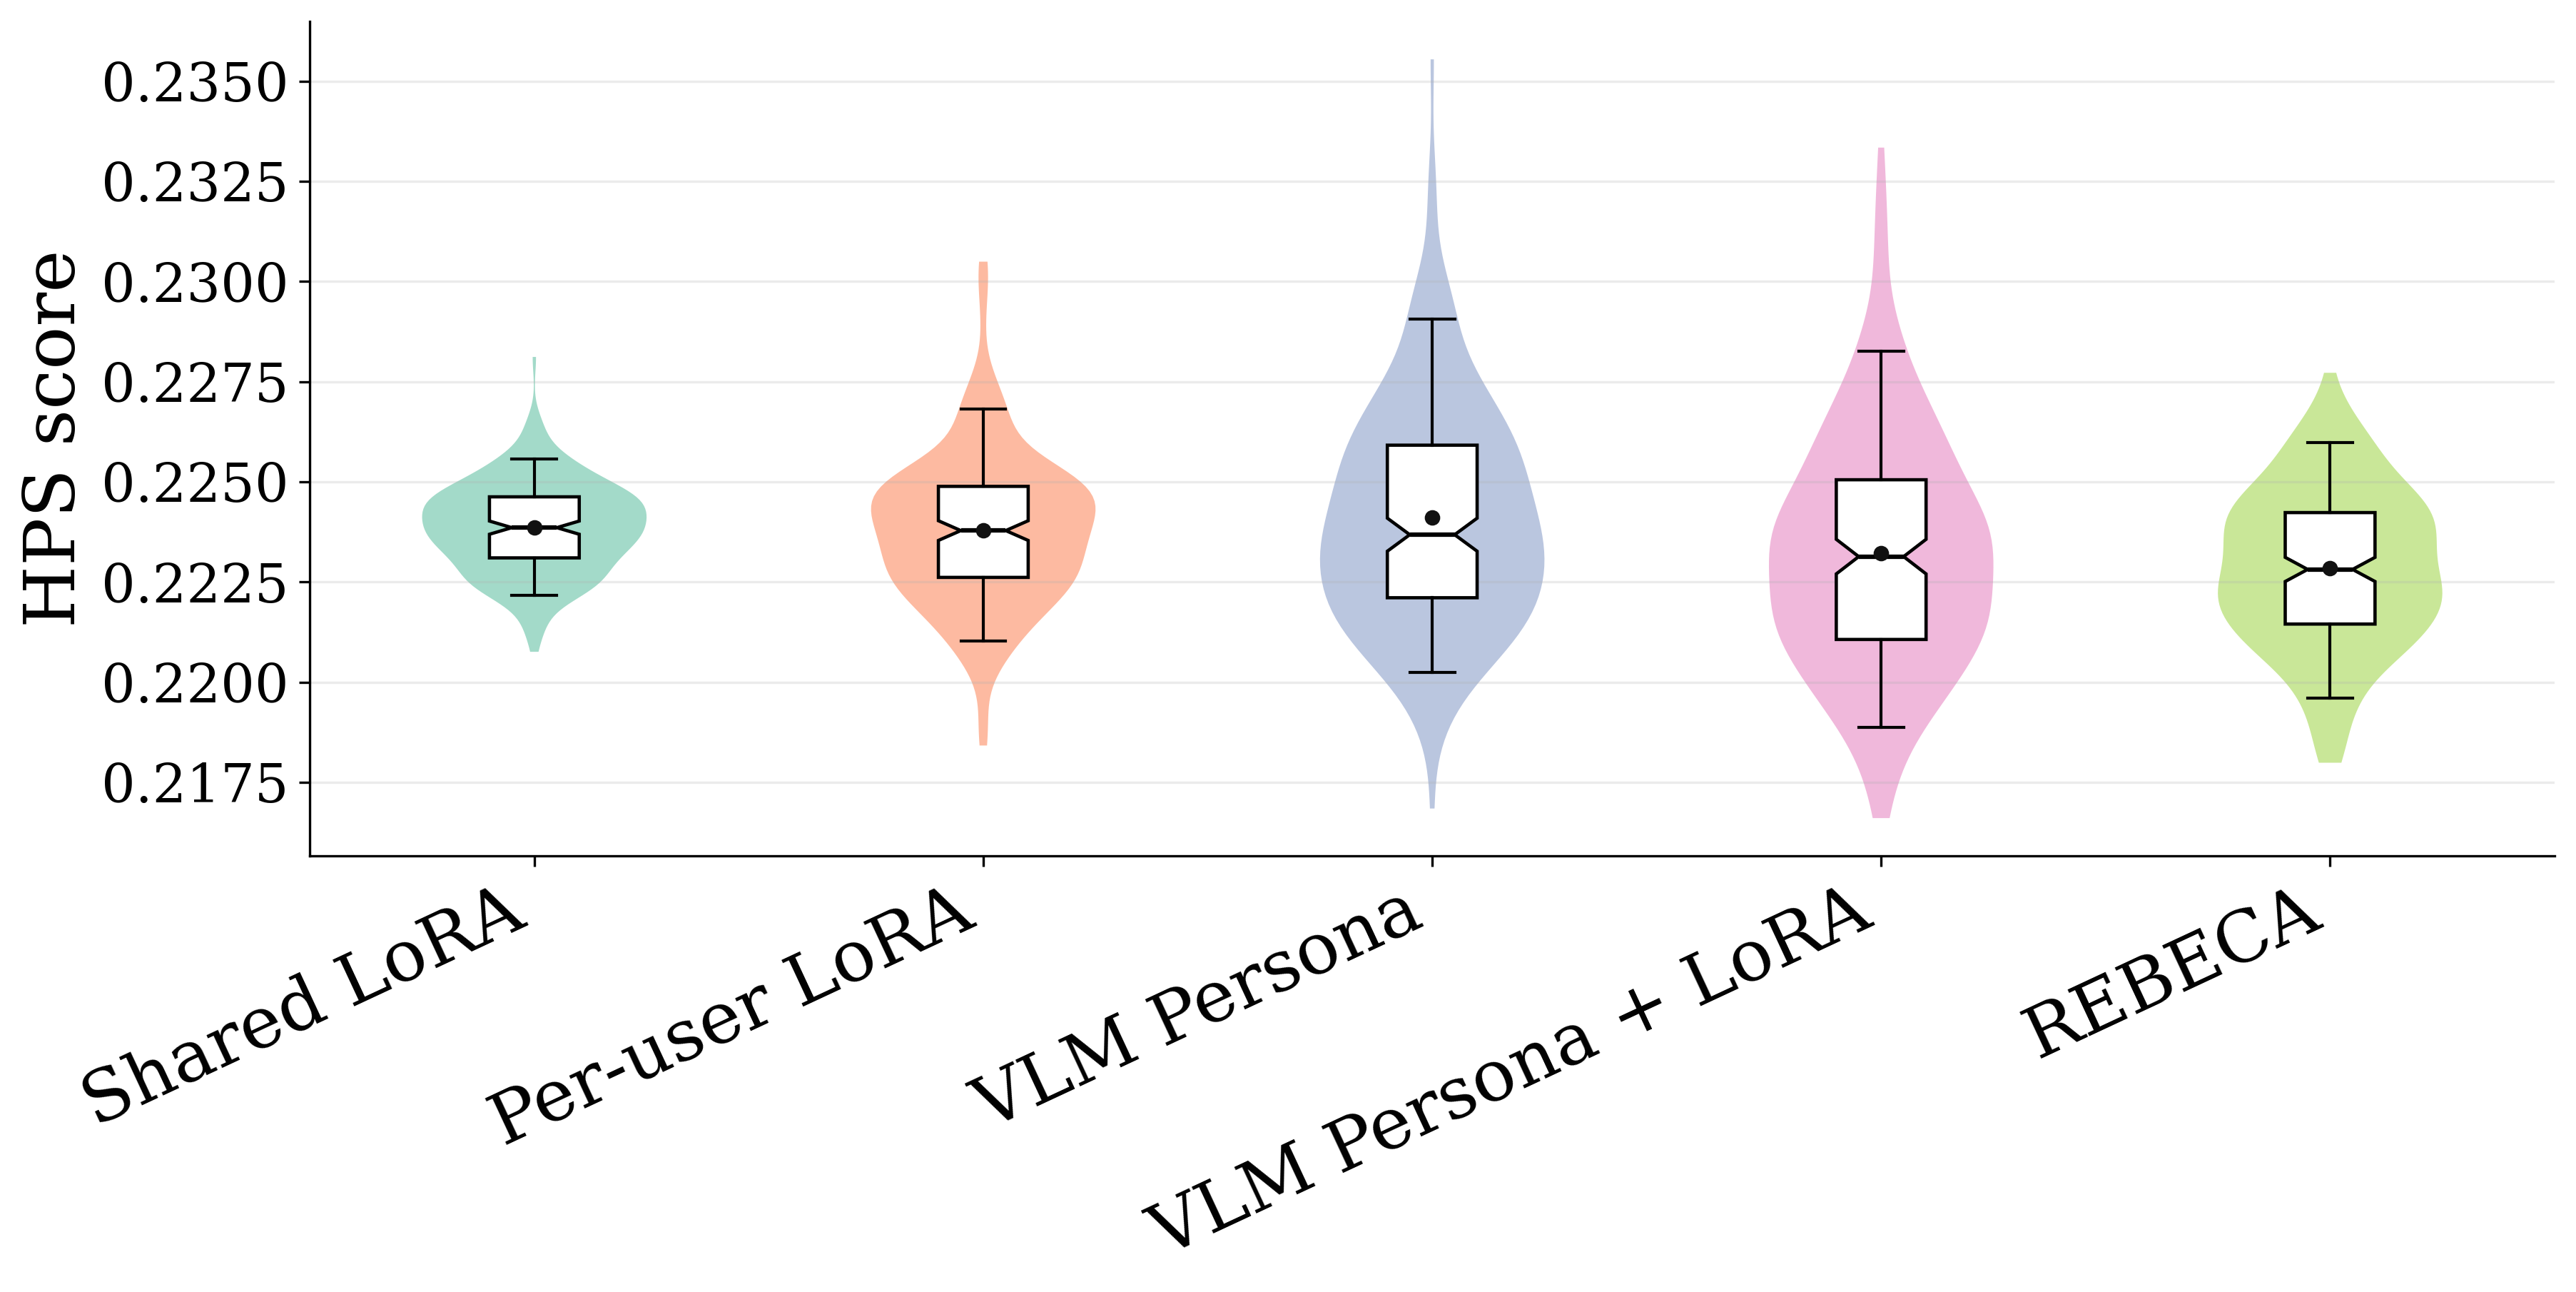

In [46]:
# Distributions across users
plot_box_distributions(per_user_means_T1, metric="hps",   title="", savepath="./figs/hps_T1.pdf")
plot_box_distributions(per_user_means_T1, metric="laion", title="", savepath="./figs/laion_T1.pdf")
plot_box_distributions(per_user_means, metric="hps",   title="", savepath="./figs/hps_T0.pdf")


In [21]:
aes_rebeca = per_user_means_T1["laion"]["REBECA"]
scores_rebeca = np.array([rebeca_scores[i]["summary"][i]["avg"] for i in range(210)])

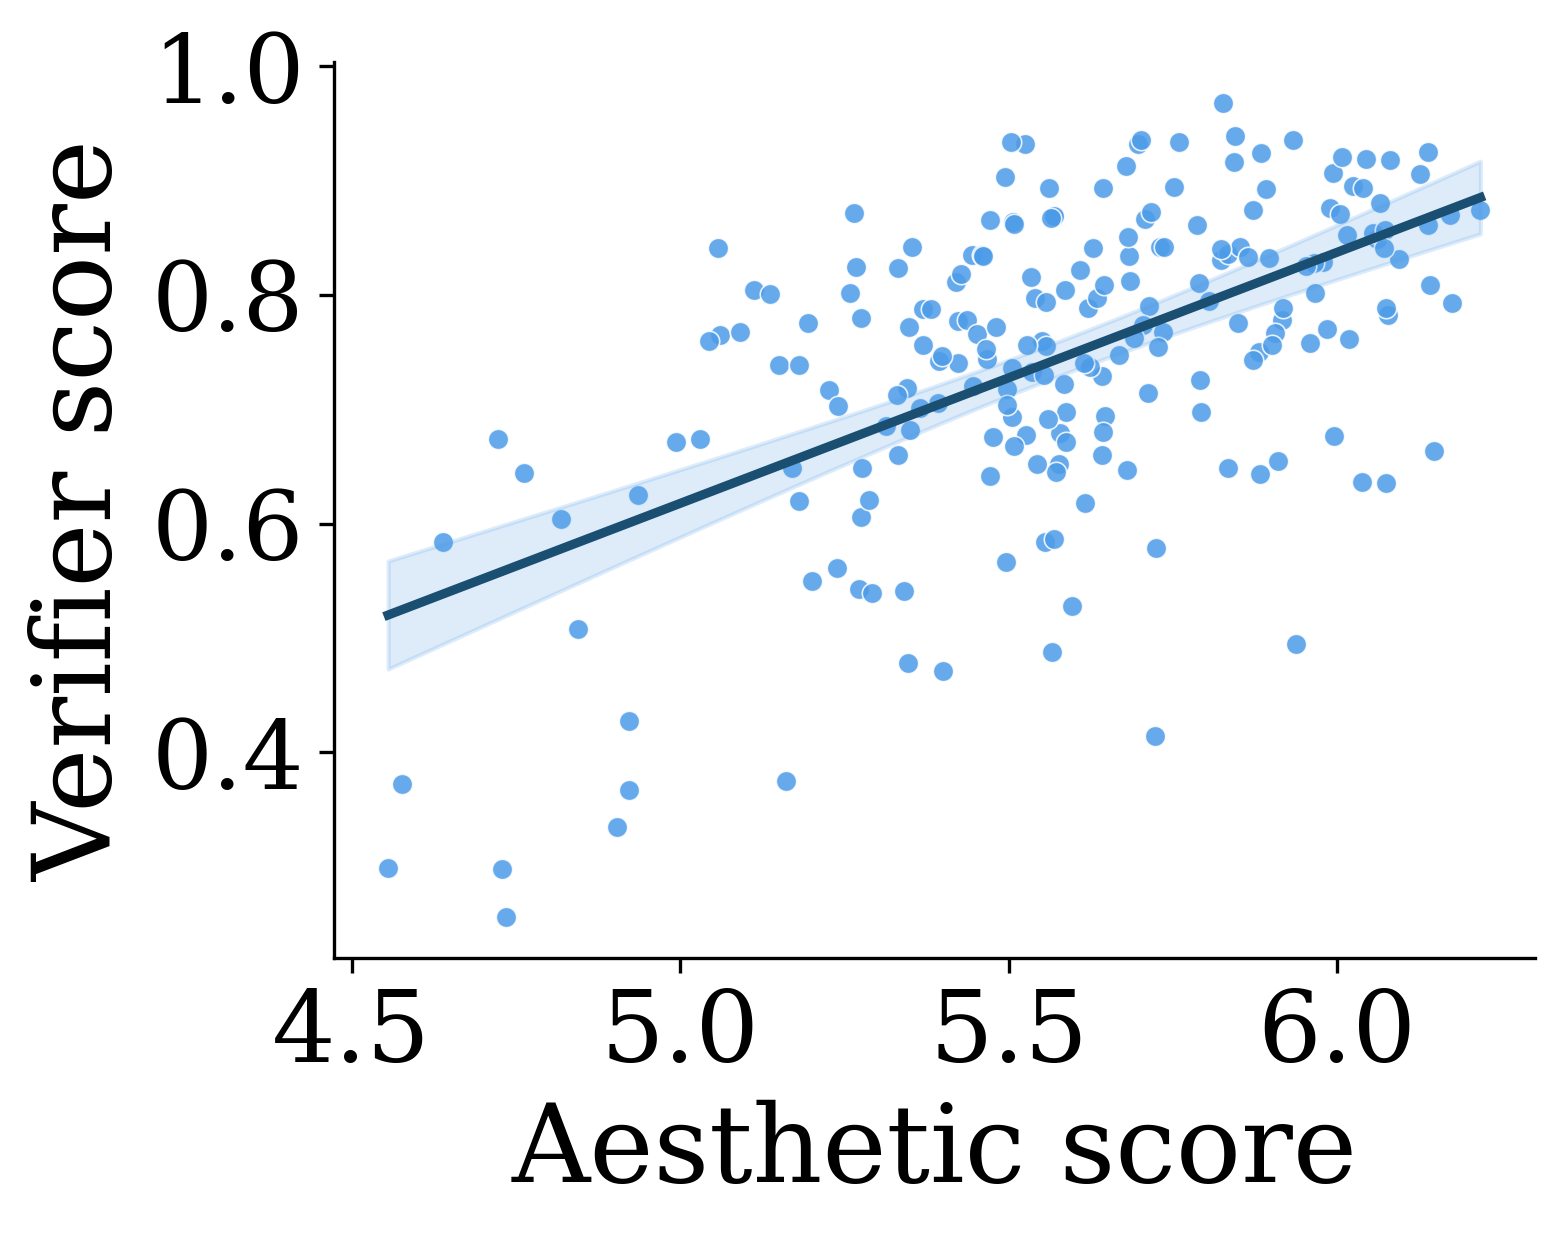

In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress, t

def plot_corr_cvpr(x, y, *, savepath=None,
                   show_labels=False,  # CVPR: keep False; describe in caption
                   point_color="#4C9BE8",   # harmonious Set2-ish blue
                   line_color="#1B4F72",    # darker blue for contrast
                   ci_alpha=0.18,
                   markersize=24):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = x.size
    assert n >= 3, "Need at least 3 points"

    # --- Pearson correlation (primary) ---
    r, p = pearsonr(x, y)

    # --- Linear fit + 95% CI of the mean trend ---
    lr = linregress(x, y)
    slope, intercept = lr.slope, lr.intercept
    xgrid = np.linspace(x.min(), x.max(), 200)
    yhat  = intercept + slope * xgrid

    xbar = x.mean()
    Sxx  = np.sum((x - xbar) ** 2)
    resid = y - (intercept + slope * x)
    s2 = np.sum(resid**2) / (n - 2)
    se_mean = np.sqrt(s2 * (1/n + (xgrid - xbar)**2 / Sxx))
    tcrit = t.ppf(0.975, df=n-2)
    lo, hi = yhat - tcrit*se_mean, yhat + tcrit*se_mean

    # --- CVPR-ish aesthetics ---
    mpl.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "savefig.transparent": True,
        "font.family": "serif",
        "axes.spines.top": False, "axes.spines.right": False,
        "axes.labelsize": 26, "xtick.labelsize": 24, "ytick.labelsize": 23,
        "axes.titlesize": 14,
    })

    fig, ax = plt.subplots(figsize=(5.2, 4.1))

    # scatter (slightly bigger markers, white edge for print)
    ax.scatter(x, y, s=markersize, color=point_color, alpha=0.85,
               edgecolor="white", linewidth=0.4, rasterized=True)

    # regression + CI
    ax.plot(xgrid, yhat, color=line_color, linewidth=2.2)
    ax.fill_between(xgrid, lo, hi, color=point_color, alpha=ci_alpha)

    # minimal axes
    if show_labels:
        ax.set_xlabel("Aesthetic score")
        ax.set_ylabel("Verifier score")
    else:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis='both', which='both', length=3)
        ax.grid(True, axis="y", linewidth=0.6, alpha=0.18)

    # subtle on-figure stat (kept small; primary text goes in caption)
    # ax.text(0.02, 0.98,
    #         rf"$r={r:.2f}$  ($p={p:.1e}$)",
    #         transform=ax.transAxes, ha="left", va="top",
    #         fontsize=11, color="#222")

    fig.tight_layout(pad=0.6)
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()

    return {"pearson_r": r, "pearson_p": p, "slope": slope, "intercept": intercept}

# usage:
stats = plot_corr_cvpr(aes_rebeca, scores_rebeca, savepath="figs/rebeca_corr.pdf", show_labels=True)


In [38]:
B=5000
boot = []
for _ in range(B):
    idx = np.random.randint(0,210,210)
    boot.append(np.corrcoef(x[idx],y[idx])[0,1])
ci = np.percentile(boot,[2.5,97.5])
print("95% CI for Pearson r:",ci)


95% CI for Pearson r: [0.36153486 0.60142559]


## Precision and Recall

In [5]:
import torch
from pathlib import Path
from tqdm import tqdm
import os

In [6]:
def l2_normalize_rows(X: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """L2-normalize each row (recommended for cosine similarity)."""
    norms = X.norm(dim=1, keepdim=True).clamp_min(eps)
    return X / norms

In [7]:
def _encode_list(img_list, pipe_xl, device="cuda", dtype=torch.float32, normalize=True):
    embs = []
    for img in img_list:
        e = pipe_xl.encode_image(img, device=device, num_images_per_prompt=1)[0]
        embs.append(e.detach().to("cpu", dtype=dtype))
    if not embs:
        return torch.empty(0, 0)
    E = torch.stack(embs, dim=0)
    return l2_normalize_rows(E) if normalize else E

def compute_model_user_embeddings(lora_dir, vlm_dir, vlm_plus_lora_dir, pipe_xl,
                                  users=range(210), device="cuda", dtype=torch.float32, normalize=True):
    out = {
        "shared_lora": {},
        "per_user_lora": {},
        "vlm_persona": {},
        "vlm_persona_plus_lora": {},
    }
    lora_dir = Path(lora_dir)
    vlm_dir = Path(vlm_dir)
    vlm_plus_lora_dir = Path(vlm_plus_lora_dir)

    for user_id in tqdm(users, desc="users"):
        shared_imgs = torch.load(lora_dir / "samples_liked/shared" / f"pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
        per_user_imgs = torch.load(lora_dir / "samples_liked/per_user" / f"pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
        vlm_imgs = torch.load(vlm_dir / "samples" / f"pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)
        vlm_plus_lora_imgs = torch.load(vlm_plus_lora_dir / "samples" / f"pipecfg_5.0_seed_42_user_{user_id}.imgs", weights_only=False)

        out["shared_lora"][user_id] = _encode_list(shared_imgs, pipe_xl, device, dtype, normalize)
        out["per_user_lora"][user_id] = _encode_list(per_user_imgs, pipe_xl, device, dtype, normalize)
        out["vlm_persona"][user_id] = _encode_list(vlm_imgs, pipe_xl, device, dtype, normalize)
        out["vlm_persona_plus_lora"][user_id] = _encode_list(vlm_plus_lora_imgs, pipe_xl, device, dtype, normalize)

    return out

In [8]:
def load_rebeca_user_embeddings(
    rebeca_dir: str,
    embcfgs=(3,5,6,9),
    users=range(210),
    *,
    normalize=True,          
    dtype=torch.float32,
    sample_k=None,           
    seed=42,                 
    strict=True              
):
    rng = torch.Generator().manual_seed(seed)
    rebeca_embeddings = {c: {} for c in embcfgs}

    for embcfg in embcfgs:
        for user_id in tqdm(users, desc=f"REBECA embcfg={embcfg}"):
            sub = f"embcfg_{embcfg}.0_pipecfg_5.0_seed_42"
            fpath = Path(rebeca_dir) / "samples" / sub / f"{sub}_userid_{user_id}.data"

            if not fpath.exists():
                if strict:
                    raise FileNotFoundError(f"Missing: {fpath}")
                else:
                    continue
            data = torch.load(fpath, weights_only=False)
            selected_images = data["images"]
            if sample_k is not None and len(selected_images) > sample_k:
                idx = torch.randperm(len(selected_images), generator=rng)[:sample_k]
                selected_images = [selected_images[i] for i in idx]
            embeddings = []
            for i in range(len(selected_images)): 
                img_embedding = pipe_xl.encode_image(selected_images[i],device="cuda", num_images_per_prompt=1)[0] 
                embeddings.append(img_embedding.detach().cpu())
            embs = torch.cat(embeddings)

            if not torch.is_tensor(embs):
                embs = torch.as_tensor(embs)
            embs = embs.to(dtype=dtype, device="cpu", non_blocking=True)
            
            if normalize:
                embs = l2_normalize_rows(embs)

            rebeca_embeddings[embcfg][user_id] = embs.contiguous()

    return rebeca_embeddings

In [13]:

embs = compute_model_user_embeddings(lora_dir, vlm_dir, vlm_plus_lora_dir, pipe_xl)
rebeca_embeddings_25 = load_rebeca_user_embeddings(rebeca_dir, embcfgs=[3, 5, 7, 9], sample_k=25)

REBECA embcfg=9: 100%|██████████| 210/210 [02:06<00:00,  1.65it/s]


In [14]:
import os, torch, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import torch, numpy as np


def l2_normalize_rows(X, eps=1e-12):
    if X.numel() == 0: return X
    n = X.norm(dim=1, keepdim=True).clamp_min(eps)
    return X / n

def encode_pil(img, pipe_xl, device="cuda", dtype=torch.float32):
    e = pipe_xl.encode_image(img, device=device, num_images_per_prompt=1)[0]
    return e.detach().to("cpu", dtype=dtype)

def cosine_topk_indices(Q: torch.Tensor, C: torch.Tensor, k: int) -> torch.Tensor:
    if Q.numel() == 0 or C.numel() == 0: 
        return torch.empty(Q.shape[0], 0, dtype=torch.long)
    return torch.topk(Q @ C.T, k=min(k, C.shape[0]), dim=1, largest=True).indices

# -------- load candidates (liked + disliked) --------
def load_candidates_liked_disliked(
    root_dir: str,
    pipe_xl,
    users=None,
    like="like",
    dislike="dislike",
    device="cuda",
    dtype=torch.float32,
    normalize=True
):
    root = Path(root_dir)
    if users is None:
        users = sorted([int(d.name) for d in root.iterdir() if d.is_dir() and d.name.isdigit()])
    candidates_by_user, labels_by_user = {}, {}
    for uid in tqdm(users, desc="candidates"):
        base = root / str(uid)
        likes_dir, dislikes_dir = base / like, base / dislike
        cand, lab = [], []
        if likes_dir.is_dir():
            for fn in os.listdir(likes_dir):
                try:
                    e = encode_pil(Image.open(likes_dir / fn), pipe_xl, device, dtype)
                    cand.append(e); lab.append(1)
                except: pass
        if dislikes_dir.is_dir():
            for fn in os.listdir(dislikes_dir):
                try:
                    e = encode_pil(Image.open(dislikes_dir / fn), pipe_xl, device, dtype)
                    cand.append(e); lab.append(0)
                except: pass
        if len(cand) == 0:
            candidates_by_user[uid] = torch.empty(0, 0)
            labels_by_user[uid] = torch.empty(0, dtype=torch.long)
            continue
        C = torch.stack(cand, dim=0)
        y = torch.as_tensor(lab, dtype=torch.long)
        candidates_by_user[uid] = l2_normalize_rows(C) if normalize else C
        labels_by_user[uid] = y
    return candidates_by_user, labels_by_user

def cosine_topk_indices(Q: torch.Tensor, C: torch.Tensor, k: int) -> torch.Tensor:
    if Q.numel() == 0 or C.numel() == 0:
        return torch.empty(Q.shape[0], 0, dtype=torch.long)
    sims = Q @ C.T                      # (n, N)
    k = min(k, C.shape[0])
    return torch.topk(sims, k=k, dim=1, largest=True).indices

def pr_at_k_for_user(gen, cand, labels, k: int, min_likes: int = 1):
    gen = gen.squeeze()
    cand = cand.squeeze()
    labels = labels if torch.is_tensor(labels) else torch.as_tensor(labels)
    if gen.numel() == 0 or cand.numel() == 0 or labels.numel() == 0:
        return np.nan, np.nan, np.nan, 0, 0
    if cand.shape[0] != labels.numel():
        raise ValueError(f"Candidates and labels must align: got {cand.shape[0]} vs {labels.numel()}")
    pos_idx = torch.nonzero(labels == 1, as_tuple=False).view(-1)
    n_pos = int(pos_idx.numel())
    if n_pos < min_likes:
        return np.nan, np.nan, np.nan, int(gen.shape[0]), n_pos
    topk = cosine_topk_indices(gen, cand, k)     # (n,k)
    rec_items = torch.unique(topk)               # indices in candidate pool
    rel_retrieved = (labels[rec_items] == 1).sum().item()
    precision = rel_retrieved / max(1, rec_items.numel())
    recall = rel_retrieved / max(1, n_pos)
    f1 = 0.0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall)
    return float(precision), float(recall), float(f1), int(gen.shape[0]), n_pos


# -------- evaluate models dict --------
def evaluate_models_at_k(models_dict, candidates_by_user, labels_by_user, ks=(1,5,10), min_likes=1):
    rows = []
    per_user = {}
    for model_name, gen_by_user in models_dict.items():
        per_user[model_name] = {}
        for k in ks:
            ps, rs, fs = [], [], []
            for uid, gen in gen_by_user.items():
                cand = candidates_by_user.get(uid, torch.empty(0,0))
                lab  = labels_by_user.get(uid, torch.empty(0, dtype=torch.long))
                p, r, f1, n_gen, n_pos = pr_at_k_for_user(gen, cand, lab, k=k, min_likes=min_likes)
                per_user[model_name].setdefault(uid, {})[f"P@{k}"] = p
                per_user[model_name][uid][f"R@{k}"] = r
                per_user[model_name][uid][f"F1@{k}"] = f1
                if not np.isnan(p): ps.append(p)
                if not np.isnan(r): rs.append(r)
                if not np.isnan(f1): fs.append(f1)
            rows.append({
                "model": model_name,
                "k": k,
                "macro_P": float(np.mean(ps)) if ps else np.nan,
                "macro_R": float(np.mean(rs)) if rs else np.nan,
                "macro_F1": float(np.mean(fs)) if fs else np.nan,
                "users_count": len(gen_by_user)
            })
    macro_df = pd.DataFrame(rows)
    return per_user, macro_df

# -------- make models dict from your variables --------
def build_models_dict(embs, rebeca_embeddings_25):
    models = {
        "Shared LoRA": embs["shared_lora"],
        "Per-user LoRA": embs["per_user_lora"],
        "VLM Persona": embs["vlm_persona"],
        "VLM Persona + LoRA": embs["vlm_persona_plus_lora"],
    }
    for cfg in sorted(rebeca_embeddings_25.keys()):
        models[f"REBECA e{cfg}"] = rebeca_embeddings_25[cfg]
    return models

# -------- plotting (CVPR-ish) --------
def plot_macro_bars(macro_df, k=5, savepath=None):
    df = macro_df[macro_df["k"] == k].copy()
    df = df.sort_values("macro_F1", ascending=False)
    mpl.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "savefig.transparent": True,
        "font.family": "serif", "axes.spines.top": False, "axes.spines.right": False,
        "axes.labelsize": 14, "xtick.labelsize": 11, "ytick.labelsize": 11,
        "legend.fontsize": 11,
    })
    melted = df.melt(id_vars=["model","k"], value_vars=["macro_P","macro_R","macro_F1"],
                     var_name="metric", value_name="score")
    plt.figure(figsize=(9.5, 4.4))
    ax = sns.barplot(data=melted, x="model", y="score", hue="metric", errorbar=None)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("")
    ax.set_ylabel(f"Score @ {k}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
    ax.legend(title="")
    plt.tight_layout(pad=0.6)
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show()


In [15]:
# 1) candidate pools (liked+disliked) from your ground-truth folders
candidates_by_user, labels_by_user = load_candidates_liked_disliked(
    root_dir=gt_savepath,
    pipe_xl=pipe_xl,
    users=range(210),      # or None to auto-discover
    like="like",
    dislike="dislike",
    device="cuda",
    normalize=True
)

# 2) build models dict from your already-loaded embeddings
models_dict = build_models_dict(embs, rebeca_embeddings_25)

candidates: 100%|██████████| 210/210 [00:39<00:00,  5.27it/s]


In [16]:


# 3) evaluate (choose ks and min_likes threshold)
per_user_metrics, macro_df = evaluate_models_at_k(
    models_dict,
    candidates_by_user,
    labels_by_user,
    ks=(1, 5),
    min_likes=3   # e.g., require at least 3 positives to include a user
)

# 4) view macro table
print(macro_df.sort_values(["k","macro_F1"], ascending=[True, False]).to_string(index=False))



             model  k  macro_P  macro_R  macro_F1  users_count
         REBECA e3  1 0.524201 0.767198  0.605160          210
         REBECA e5  1 0.556344 0.714154  0.604992          210
         REBECA e7  1 0.579971 0.646811  0.584519          210
         REBECA e9  1 0.604781 0.610463  0.575323          210
     Per-user LoRA  1 0.484588 0.713255  0.556748          210
       VLM Persona  1 0.507277 0.684968  0.556349          210
VLM Persona + LoRA  1 0.511388 0.673390  0.554949          210
       Shared LoRA  1 0.454510 0.717675  0.539664          210
         REBECA e9  5 0.483828 0.972247  0.630550          210
         REBECA e3  5 0.477563 0.996705  0.630101          210
         REBECA e5  5 0.477719 0.988841  0.629027          210
         REBECA e7  5 0.480927 0.976101  0.628558          210
VLM Persona + LoRA  5 0.475330 0.985876  0.625715          210
       Shared LoRA  5 0.470579 0.990962  0.622875          210
       VLM Persona  5 0.471518 0.983110  0.621005      

In [17]:
macro_df

,model,k,macro_P,macro_R,macro_F1,users_count
0,Shared LoRA,1,0.454510,0.717675,0.539664,210
1,Shared LoRA,5,0.470579,0.990962,0.622875,210
2,Per-user LoRA,1,0.484588,0.713255,0.556748,210
3,Per-user LoRA,5,0.469640,0.986033,0.620966,210
4,VLM Persona,1,0.507277,0.684968,0.556349,210
5,VLM Persona,5,0.471518,0.983110,0.621005,210
6,VLM Persona + LoRA,1,0.511388,0.673390,0.554949,210
7,VLM Persona + LoRA,5,0.475330,0.985876,0.625715,210
8,REBECA e3,1,0.524201,0.767198,0.605160,210
9,REBECA e3,5,0.477563,0.996705,0.630101,210
